[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Bradley-Buchner/cs7170_project/blob/main/bivi_investigation.ipynb)

# Investigation of *biVI*: a biophysically-grounded VAE for scRNA-seq data analysis

This notebook contains two analyses of *biVI* that illustrate its value over standard *scVI*. The first shows how *biVI* is able to distinguish between real and biophysically implausible data better than *scVI*. The second assesses how much biological information *biVI* captures that *scVI* does not.

Disclaimer: some of the preprocessing code below is borrowed from the authors' demo of *biVI* ([Demo.ipynb](https://github.com/pachterlab/CGCCP_2023/blob/main/Example/Demo.ipynb)).

In [ ]:
%git clone https://github.com/pachterlab/CGCCP_2023.git
%pip install -r requirements.txt
# %cd /content/CGCCP_2023/

In [ ]:
import os

print(f"Current wd: {os.getcwd()}")
os.chdir('CGCCP_2023')
print(f"Updated wd: {os.getcwd()}")

In [ ]:
%pip uninstall torchmetrics -y # need for compatibility with scVI version
%pip install -qr ./Manuscript/analysis/requirements.txt
%pip install -q ./BIVI/

In [ ]:
# --- Import calls ---
# import sys
# # sys.path.append('../')
import numpy as np
import anndata
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import pandas as pd
import warnings
import torch

from BIVI import biVI
import scvi
from tools import generate_incoherent_data, plot_ood_separation, single_pair_kinetic_compensation, multi_pair_kinetic_compensation

np.random.seed(23)
warnings.filterwarnings("ignore", category=UserWarning)

### Prepare scRNA-seq data
Load a single-cell RNA sequencing dataset, filter it for quality control, and select the most informative genes. Then reformat the data by concatenating the spliced and unspliced RNA count matrices along the cell axis to prepare it for modeling.

In [5]:
# --- Load data and prepare for modeling ---
# *** code borrowed from "Demo.ipynb" in biVI repo ***
data_path = 'Example/pbmc_1k_v3/counts_filtered/adata.loom'
adata = sc.read_loom(data_path)

if 'gene_name' in adata.var.columns:
    adata.var_names = adata.var['gene_name'].to_list()
adata.var_names_make_unique()

# standard filtering of uninformative genes and cells (same as biVI demo)
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)
adata.var['mt'] = adata.var_names.str.startswith('MT-')
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
adata = adata[adata.obs.total_counts > 1000, :]
adata = adata[adata.obs.pct_counts_mt < 30, :]

# select the 2000 most variable genes
adata_norm = adata.copy()
sc.pp.normalize_total(adata_norm, target_sum=1e4)
sc.pp.log1p(adata_norm)
sc.pp.highly_variable_genes(adata_norm, n_top_genes=2000, min_mean=0.0125, max_mean=3, min_disp=0.5)
adata = adata[:, adata_norm.var.highly_variable].copy()

# restructure the data so that unspliced (nascent) and spliced (mature) RNA counts are concatenated into one matrix
adata_old = adata.copy()
adata_spliced = anndata.AnnData(adata.layers['spliced'])
adata_unspliced = anndata.AnnData(adata.layers['unspliced'])
adata_spliced.var = adata.var.copy()
adata_unspliced.var = adata.var.copy()
adata_spliced.var['Spliced'] = True
adata_unspliced.var['Spliced'] = False
adata_unspliced.var_names = adata_unspliced.var_names + '-u'
adata = anndata.concat([adata_unspliced, adata_spliced], axis=1)
adata.layers["counts"] = adata.X.copy()
adata.obs = adata_old.obs.copy()

print(f"Final data shape: {adata.shape} (Cells x [Unspliced + Spliced Genes])")

Final data shape: (1096, 4000) (Cells x [Unspliced + Spliced Genes])


Randomly shuffle the dataset's rows (cells) and split them 90/10 for training and testing.

In [6]:
# --- Generate indices for train/test split ---
n_cells = adata.n_obs
indices = np.random.permutation(n_cells)

split_point = int(0.9 * n_cells)
train_indices = indices[:split_point]
test_indices = indices[split_point:]

print(f"Training cells: {len(train_indices)}")
print(f"Testing cells: {len(test_indices)}")

adata_train = adata[train_indices].copy()
adata_test = adata[test_indices].copy()

Training cells: 986
Testing cells: 110


## Train a *scVI* model
Initialize and configure a *scVI* model with the same architectural settings as those used in the *biVI* paper (3 layers, 128 nodes, 10 latent dimensions). Also set the gene likelihood to a Negative Binomial (NB) distribution.

In [7]:
# --- Set up a scVI model ---
# use setup_anndata() to point scVI at the raw counts
scvi.model.SCVI.setup_anndata(
    adata_train,
    layer="counts"
)

# define the model and set hyperparameters
scvi_model = scvi.model.SCVI(
    adata_train,
    n_hidden=128,
    n_layers=3,
    n_latent=10,
    gene_likelihood="nb"
)

Set a seed for the *scVI* model so that its train/validation split is reproducible and train it, passing hyperparameters that match those used in the *biVI* demo (max_epochs=100 and train_size=0.9).

In [8]:
# --- Train the scVI model ---
scvi.settings.seed = 23   # this seed is also inherited by biVI

scvi_accelerator = "mps" if torch.backends.mps.is_available() else ("cuda" if torch.cuda.is_available() else "cpu")

scvi_model.train(
    max_epochs=100,
    train_size=0.9,
    check_val_every_n_epoch=1,
    accelerator=scvi_accelerator
)

Seed set to 23
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores


Training:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


After training *scVI*, plot the Evidence Lower Bound (ELBO) for the training and validation sets over all epochs.

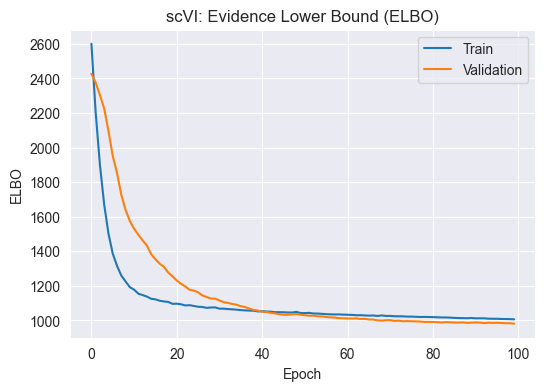

In [9]:
# --- Visualize training results ---
# *** code borrowed from "Demo.ipynb" in biVI repo ***
# plot Evidence Lower Bound (ELBO)
plt.figure(figsize=(6, 4))
plt.plot(scvi_model.history["elbo_train"], label="Train")
if "elbo_validation" in scvi_model.history:
    plt.plot(scvi_model.history["elbo_validation"], label="Validation")
plt.title("scVI: Evidence Lower Bound (ELBO)")
plt.xlabel("Epoch")
plt.ylabel("ELBO")
plt.legend()
plt.show()

Extract low-dimensional latent representations for each cell using the trained *scVI* model, perform clustering, and use UMAP to visualize the underlying structure of the data.

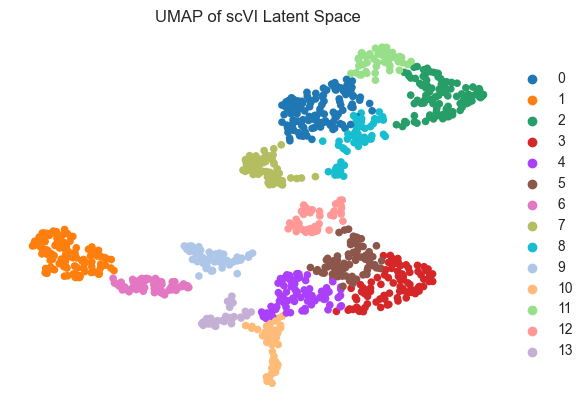

In [11]:
# --- Extract latent representations ---
# *** code borrowed from "Demo.ipynb" in biVI repo ***

# add latent reps to anndata object
Z_scvi = scvi_model.get_latent_representation()
adata_train.obsm["Z_scvi"] = Z_scvi

# plot clustering of the scVI latent space
sc.pp.neighbors(adata_train, use_rep="Z_scvi")
sc.tl.umap(adata_train)
sc.tl.leiden(adata_train)

sc.pl.umap(
    adata_train,
    color=["leiden"],
    title="UMAP of scVI Latent Space",
    frameon=False
)

## Train a *biVI* model
Initialize and configure a *biVI* model with the same architectural settings as the *biVI* demo.

In [12]:
# --- Set up a bivi model ---
# *** code borrowed from "Demo.ipynb" in biVI repo ***
biVI.biVI.setup_anndata(adata_train, layer="counts")

# model arguments
model_args = {
    'n_latent': 10,
    'n_layers': 3,
    'dispersion': 'gene',
    'n_hidden': 128,
    'dropout_rate':  0.1,
    'log_variational':  True,
    'latent_distribution':  'normal',
}

# define biVI model
bivi_model = biVI.biVI(adata_train, mode='Bursty', **model_args)

{'n_input': 4000, 'n_hidden': 128, 'n_latent': 10, 'n_layers': 3, 'dropout_rate': 0.1, 'dispersion': 'gene', 'latent_distribution': 'normal', 'log_variational': True}
Initiating biVAE
Mode: Bursty, Decoder: non-linear, Theta is: NAS_SHAPE


Train the model with the same training plan as the *biVI* demo, using the same values as *scVI* for max_epochs and train_size. The *biVI* model automatically inherits the reproducibility seed set for *scVI*, so the training/validation split will be identical.

In [13]:
# --- Train the bivi model (should take a few minutes) ---
# training plan parameters
max_epochs = 100
plan_kwargs = {
    'lr' : 0.001,
    'n_epochs_kl_warmup' : max_epochs/2
}
bivi_accelerator = "cuda" if torch.cuda.is_available() else "cpu"

bivi_model.train(max_epochs=max_epochs,
                train_size=0.9,
                check_val_every_n_epoch=1,
                accelerator=bivi_accelerator,
                plan_kwargs=plan_kwargs)

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores


Training:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


Once again, plot the Evidence Lower Bound (ELBO) for training and validation sets over all epochs.

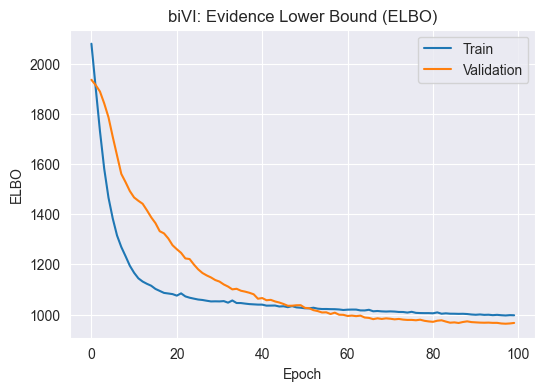

In [16]:
# --- Visualize training results ---
# *** code borrowed from "Demo.ipynb" in biVI repo ***
# plot evidence Lower Bound (ELBO)
plt.figure(figsize=(6, 4))
plt.plot(bivi_model.history["elbo_train"], label="Train")
if "elbo_validation" in bivi_model.history:
    plt.plot(bivi_model.history["elbo_validation"], label="Validation")
plt.title("biVI: Evidence Lower Bound (ELBO)")
plt.xlabel("Epoch")
plt.ylabel("ELBO")
plt.legend()
plt.show()

Like before, extract cell latent representations using the trained *biVI* model, perform clustering, and use UMAP to visualize the data's underlying structure.

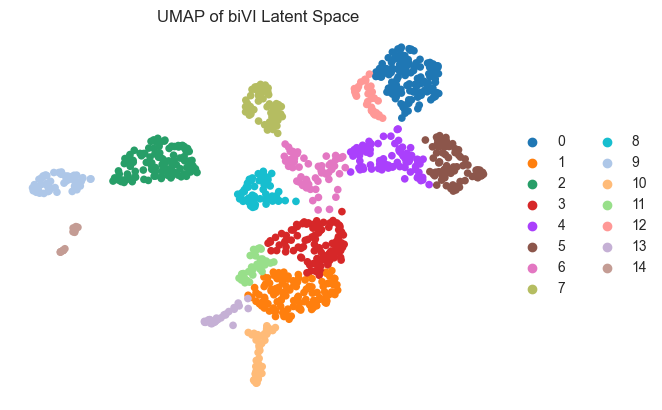

In [17]:
# --- Extract latent representations ---
# *** code borrowed from "Demo.ipynb" in biVI repo ***

# add latent reps to anndata object
Z_bivi = bivi_model.get_latent_representation()
adata_train.obsm["Z_bivi"] = Z_bivi

# plot clustering of the biVI latent space
sc.pp.neighbors(adata_train, use_rep="Z_bivi")
sc.tl.umap(adata_train)
sc.tl.leiden(adata_train)

sc.pl.umap(
    adata_train,
    color=["leiden"],
    title="UMAP of biVI Latent Space",
    frameon=False
)

## Analysis 1: Distinguishing between real and biophysically implausible data
This analysis investigates whether biVI's biophysical grounding allows it to learn biological laws better than scVI. Below, pre-trained biVI and scVI models are tested on real and compromised test data, which is created by randomly shuffling cells' mature RNA counts to decouple them from their corresponding nascent counts. With these datasets, each model is assessed on how much more sensitive it is to the compromised data by comparing the change in reconstruction error. If biVI learns representations during training that more accurately capture the mechanistic link between nascent and mature RNA counts, then biVI should struggle more than scVI in reconstructing compromised data. In other words, scVI should not see as much of a performance hit when presented with the compromised data. This analysis is meant to evaluate whether biVI’s generative process is more biologically faithful, checking to see if it effectively 'flags' data that contradicts the known laws of cellular dynamics.

Identify cell types in the test data, create a compromised dataset by shuffling mature RNA counts to disrupt nascent-mature dependency, and calculate the reconstruction error for *scVI* and *biVI* on both datasets to evaluate how well each model distinguishes real biological patterns from degraded ones.

In [18]:
# --- Pass real and fake data to pre-trained models ---
# prepare data and identify cell types
print("Clustering cell types in held-out data with scVI...")
sc.pp.pca(adata_test)
sc.pp.neighbors(adata_test)
sc.tl.leiden(adata_test, key_added="leiden")
print(f"Done! Identified {len(adata_test.obs['leiden'].unique())} clusters in test data.\n")

# create fake dataset by swapping mature RNA counts between cells of the same type
print("Creating fake dataset from held-out data...")
adata_fake = generate_incoherent_data(adata_test)
print("Done!\n")

# scVI eval
print("Evaluating scVI on real and fake datasets...")
scvi_nll_real = {'reconstruction_loss': scvi_model.get_reconstruction_error(adata_test, return_mean=False)}
scvi_nll_fake = {'reconstruction_loss': scvi_model.get_reconstruction_error(adata_fake, return_mean=False)}
print("Done!\n")

# biVI eval
print("Evaluating biVI on real and fake datasets...")
bivi_nll_real = {'reconstruction_loss': bivi_model.get_reconstruction_error(adata_test, return_mean=False)}
bivi_nll_fake = {'reconstruction_loss': bivi_model.get_reconstruction_error(adata_fake, return_mean=False)}
print("Done!\n")

Clustering cell types in held-out data with scVI...
Done! Identified 4 clusters in test data.

Creating fake dataset from held-out data...
Done!

Evaluating scVI on real and fake datasets...
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
Done!

Evaluating biVI on real and fake datasets...
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
Done!



### Visualize *scVI* and *biVI* on real and fake data
 Plot the distributions of reconstruction error for *scVI* and *biVI* on both the real and fake (compromised) datasets. Also compute a "rejection score", which measures the separation between real and fake distributions for each model, where a high score means that the model properly gives a higher error to the fake data. This score allows for the comparison of *scVI* and *biVI*.

scVI Rejection Score: 0.25
biVI Rejection Score: 0.38

RESULT: biVI is more likely to reject fake data than scVI.


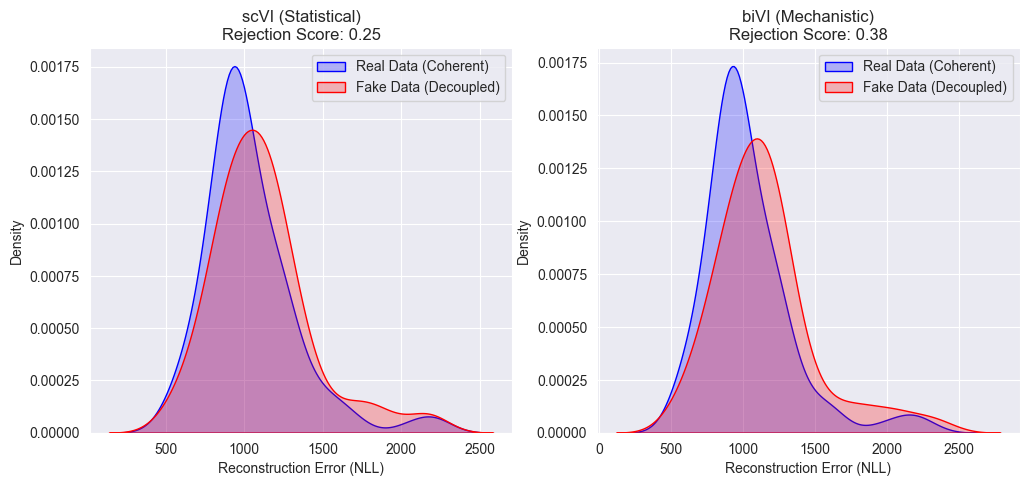

In [19]:
# --- Plot each model's distributions of real and fake reconstruction error ---
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

plot_ood_separation(scvi_nll_real, scvi_nll_fake, "scVI (Statistical)", axes[0])
plot_ood_separation(bivi_nll_real, bivi_nll_fake, "biVI (Mechanistic)", axes[1])

scvi_nll_fake_np = scvi_nll_fake['reconstruction_loss']['reconstruction_loss'].cpu().numpy()
scvi_nll_real_np = scvi_nll_real['reconstruction_loss']['reconstruction_loss'].cpu().numpy()
bivi_nll_fake_np = bivi_nll_fake['reconstruction_loss']['reconstruction_loss'].cpu().numpy()
bivi_nll_real_np = bivi_nll_real['reconstruction_loss']['reconstruction_loss'].cpu().numpy()

scvi_score = (np.mean(scvi_nll_fake_np) - np.mean(scvi_nll_real_np)) / np.std(scvi_nll_real_np)
bivi_score = (np.mean(bivi_nll_fake_np) - np.mean(bivi_nll_real_np)) / np.std(bivi_nll_real_np)

print(f"scVI Rejection Score: {scvi_score:.2f}")
print(f"biVI Rejection Score: {bivi_score:.2f}")

if bivi_score > scvi_score:
    print("\nRESULT: biVI is more likely to reject fake data than scVI.")
else:
    print("\nRESULT: scVI is more likely to reject fake data than biVI.")

### Determine statistical significance
Perform a bootstrap analysis to statistically compare the ability of *scVI* and *biVI* to distinguish real biological data from the compromised data. Calculate a p-value by resampling the model error distributions many times to determine if *biVI*’s detection of non-biological samples is significantly better than *scVI*'s.

Running 10000 bootstrap iterations...


100%|██████████| 10000/10000 [00:00<00:00, 32793.67it/s]



Mean Bootstrap Score (scVI): 0.260 +/- 0.063
Mean Bootstrap Score (biVI): 0.389 +/- 0.074
Mean Difference (biVI - scVI): 0.129
P-Value (One-sided): 0.00000
RESULT: Significant. The improvement in Rejection Score (biVI - scVI) is statistically significant.


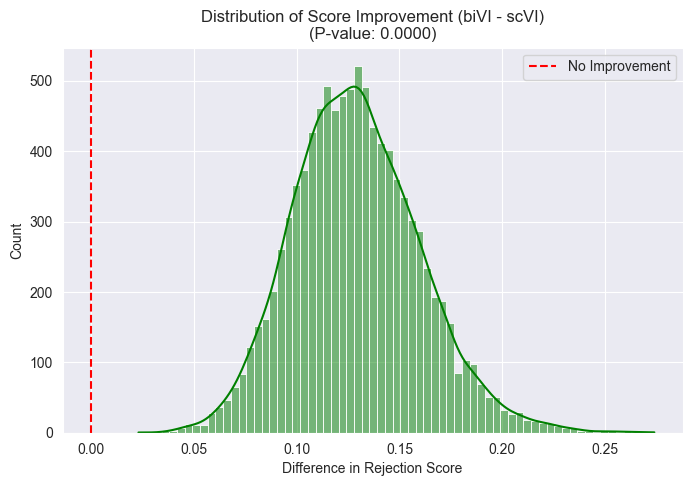

In [20]:
# bootstrap to get an estimate of the probability of obtaining a score this extreme
n_bootstraps = 10000
scvi_scores_boot = []
bivi_scores_boot = []
score_differences = [] # biVI - scVI

n_samples = len(scvi_nll_real_np)

print(f"Running {n_bootstraps} bootstrap iterations...")
for i in tqdm(range(n_bootstraps)):
    indices = np.random.choice(n_samples, n_samples, replace=True)

    sr_boot = scvi_nll_real_np[indices]
    sf_boot = scvi_nll_fake_np[indices]
    br_boot = bivi_nll_real_np[indices]
    bf_boot = bivi_nll_fake_np[indices]

    # Rejection Score = (Mean_Fake - Mean_Real) / Std_Real
    s_score = (np.mean(sf_boot) - np.mean(sr_boot)) / np.std(sr_boot)
    b_score = (np.mean(bf_boot) - np.mean(br_boot)) / np.std(br_boot)

    scvi_scores_boot.append(s_score)
    bivi_scores_boot.append(b_score)
    score_differences.append(b_score - s_score)

# null hypothesis: biVI score <= scVI score (difference <= 0)
# p-value = fraction of bootstraps where scVI beat or tied biVI
score_differences = np.array(score_differences)
p_value = np.mean(score_differences <= 0)

print(f"\nMean Bootstrap Score (scVI): {np.mean(scvi_scores_boot):.3f} +/- {np.std(scvi_scores_boot):.3f}")
print(f"Mean Bootstrap Score (biVI): {np.mean(bivi_scores_boot):.3f} +/- {np.std(bivi_scores_boot):.3f}")
print(f"Mean Difference (biVI - scVI): {np.mean(score_differences):.3f}")
print(f"P-Value (One-sided): {p_value:.5f}")

if p_value < 0.05:
    print("RESULT: Significant. The improvement in Rejection Score (biVI - scVI) is statistically significant.")
else:
    print("RESULT: Not Significant. The improvement in Rejection Score (biVI - scVI) is NOT statistically significant.")

# plot bootstrap results
plt.figure(figsize=(8, 5))
sns.histplot(score_differences, kde=True, color='green')
plt.axvline(0, color='red', linestyle='--', label='No Improvement')
plt.title(f"Distribution of Score Improvement (biVI - scVI)\n(P-value: {p_value:.4f})")
plt.xlabel("Difference in Rejection Score")
plt.legend()
plt.show()

## Analysis 2: Quantifying hidden gene regulation with biVI
This analysis aims to measure the amount of biological information that is captured by *biVI* but is missed by *scVI*. It focuses on the phenomenon of "kinetic compensation", where a gene’s RNA abundance remains stable between cell types because the cell actively balances changes in production (burst size, $b$) with corresponding changes in degradation ($\gamma/k$). Below, genes whose average RNA levels remain stable between two cell clusters are identified and *biVI*'s inferred kinetic parameters are used to determine if those stable levels are maintained by compensatory changes in burst size and degradation rate. By using *biVI* to quantify the prevalence of this type of compensation across all genes and cell type pairs, we can get a sense of how much biological information is gained by *biVI* compared to *scVI*.

### Single-pair kinetic compensation analysis
Run a pairwise analysis to reveal kinetic compensation across all genes with stable expression across two cell types. Kinetically compensating genes represent changes in biological activity across cells but not mean expression.

In [21]:
# --- Run a pairwise iso-expression analysis ---
single_pair_results = single_pair_kinetic_compensation(adata_test, bivi_model, cluster_indices=(0, 1), cluster_key='leiden', lfc_threshold=0.5, mean_threshold=0.1)

total_genes = single_pair_results["total_genes"]
iso_genes_idx = single_pair_results["iso_genes_idx"]
compensating_genes_mask = single_pair_results["compensating_mask"]

print(f"Total genes: {total_genes}")
print(f"Stable 'iso-expression' genes: {len(iso_genes_idx)} ({len(iso_genes_idx)/total_genes*100:.1f}%)")

num_comp = np.sum(compensating_genes_mask)
pct_comp_of_iso = num_comp / len(iso_genes_idx) * 100
pct_comp_global = num_comp / total_genes * 100

print(f"Genes with kinetic compensation: {num_comp}")
print(f"Percentage of iso-expression genes: {pct_comp_of_iso:.1f}%")
print(f"Percentage of global transcriptome: {pct_comp_global:.1f}%")

Comparing cell types 0 and 1...

Extracting biVI kinetic parameters...
Bursty mode, getting parameters

Quantifying kinetic compensation...
Total genes: 2000
Stable 'iso-expression' genes: 65 (3.2%)
Genes with kinetic compensation: 24
Percentage of iso-expression genes: 36.9%
Percentage of global transcriptome: 1.2%



Visualizing kinetic compensation...


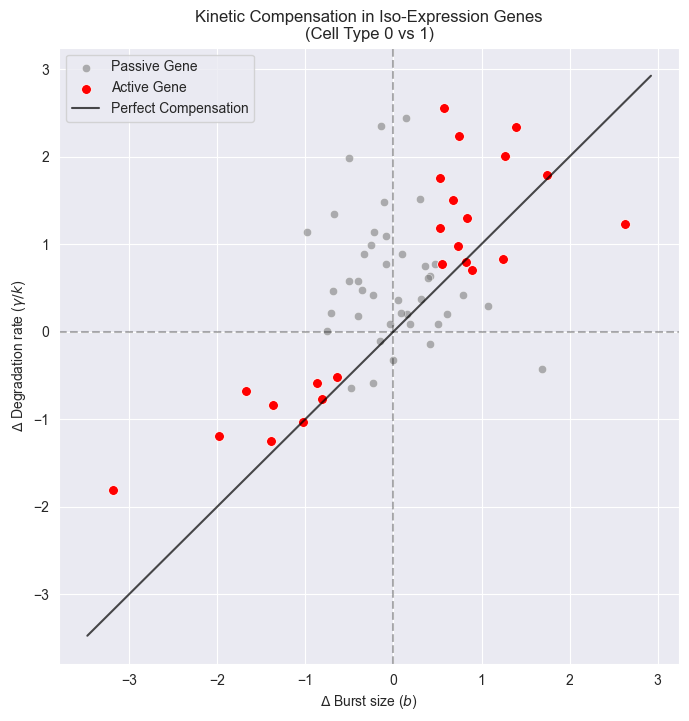


Top 5 genes with the most hidden regulation (large Δ b and Δ γ/k, but no change in mean expression):
PTGER2: Δ b=-3.18, Δ γ/k=-1.81
TIGIT: Δ b=2.63, Δ γ/k=1.23
IRF7: Δ b=-1.98, Δ γ/k=-1.19
HLA-DQA2: Δ b=1.74, Δ γ/k=1.79
PMAIP1: Δ b=-1.67, Δ γ/k=-0.68


In [22]:
# --- Visualize kinetic compensation ---
print("\nVisualizing kinetic compensation...")
lfc_b = single_pair_results["lfc_burst"]
lfc_gamma = single_pair_results["lfc_degradation"]
cluster_A, cluster_B = single_pair_results["clusters"]
gene_names = single_pair_results["gene_names"]

plt.figure(figsize=(8, 8))
sns.scatterplot(x=lfc_b, y=lfc_gamma, alpha=0.6, color='grey', label='Passive Gene')

if num_comp > 0:
    sns.scatterplot(x=lfc_b[compensating_genes_mask], y=lfc_gamma[compensating_genes_mask],
                    color='red', s=50, label='Active Gene')
plt.axhline(0, color='k', linestyle='--', alpha=0.3)
plt.axvline(0, color='k', linestyle='--', alpha=0.3)
lims = [np.min([plt.xlim(), plt.ylim()]), np.max([plt.xlim(), plt.ylim()])]
plt.plot(lims, lims, 'k-', alpha=0.7, label='Perfect Compensation')

plt.title(f"Kinetic Compensation in Iso-Expression Genes\n(Cell Type {cluster_A} vs {cluster_B})")
plt.xlabel("$\\Delta$ Burst size ($b$)")
plt.ylabel("$\\Delta$ Degradation rate ($\\gamma/k$)")
plt.legend()
plt.show()

# list top compensating genes
if num_comp > 0:
    comp_gene_names = gene_names[iso_genes_idx][compensating_genes_mask]
    magnitudes = np.abs(lfc_b[compensating_genes_mask])
    sorted_indices = np.argsort(magnitudes)[::-1]
    print("\nTop 5 genes with the most hidden regulation (large Δ b and Δ γ/k, but no change in mean expression):")
    for i in sorted_indices[:5]:
        print(f"{comp_gene_names[i]}: Δ b={lfc_b[compensating_genes_mask][i]:.2f}, Δ γ/k={lfc_gamma[compensating_genes_mask][i]:.2f}")

### Global kinetic compensation analysis
Scale the kinetic compensation analysis up to the entire held-out dataset by systematically comparing every possible pair of cell clusters to identify genes with stable expression but shifting regulatory parameters. Quantify the frequency of these instances to get a sense of the extent of hidden regulation.

In [23]:
# --- Run kinetic compensation analysis on all pairs of cell types ---"
multi_pair_results = multi_pair_kinetic_compensation(adata_test, bivi_model, cluster_key='leiden', min_cells=10,
                                    lfc_threshold=0.5, mean_threshold=0.1, min_stable_genes=10)

all_lfc_b = np.concatenate([r['lfc_burst'] for r in multi_pair_results])
all_lfc_gamma = np.concatenate([r['lfc_gamma'] for r in multi_pair_results])
all_mask_comp = np.concatenate([r['mask_comp'] for r in multi_pair_results])

total_stable_instances = len(all_lfc_b)
total_comp_instances = np.sum(all_mask_comp)
global_pct = (total_comp_instances / total_stable_instances) * 100

print(f"\n=== Global analysis across {len(multi_pair_results)} cell type pairs: ===")
print(f"Total stable gene instances: {total_stable_instances}")
print(f"Total kinetic compensation instances: {total_comp_instances}")
print(f"Global prevalence: {global_pct:.1f}%")

Running iso-expression analysis on all cell-type pairs...

Analyzing 4 valid clusters (>10 cells).
Processing 6 cluster pairs...
Extracting global biVI parameters...
Bursty mode, getting parameters


Analyzing cluster pairs: 100%|██████████| 6/6 [00:00<00:00, 4963.67it/s]


=== Global analysis across 6 cell type pairs: ===
Total stable gene instances: 394
Total kinetic compensation instances: 90
Global prevalence: 22.8%



Visualizing global kinetic compensation...


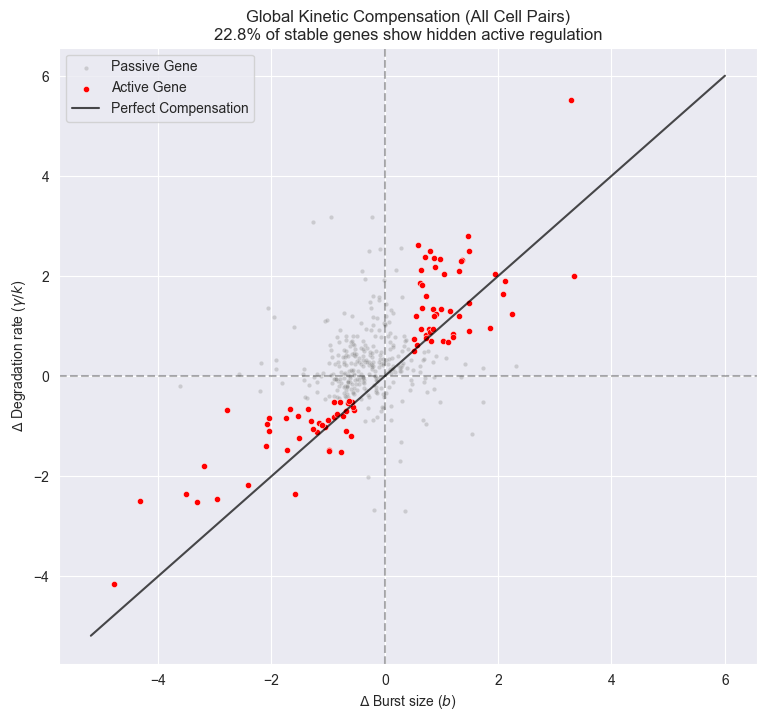

In [24]:
# --- Global visualization and summary ---
print("\nVisualizing global kinetic compensation...")

# plot global results
plt.figure(figsize=(9, 8))
plot_b, plot_g, plot_m = all_lfc_b, all_lfc_gamma, all_mask_comp

sns.scatterplot(x=plot_b, y=plot_g, alpha=0.3, color='grey', s=10, label='Passive Gene')
sns.scatterplot(x=plot_b[plot_m], y=plot_g[plot_m], color='red', s=20, label='Active Gene')

plt.axhline(0, color='k', linestyle='--', alpha=0.3)
plt.axvline(0, color='k', linestyle='--', alpha=0.3)
lims = [np.min([plt.xlim(), plt.ylim()]), np.max([plt.xlim(), plt.ylim()])]
plt.plot(lims, lims, 'k-', alpha=0.7, label='Perfect Compensation')

plt.title(f"Global Kinetic Compensation (All Cell Pairs)\n{global_pct:.1f}% of stable genes show hidden active regulation")
plt.xlabel("$\\Delta$ Burst size ($b$)")
plt.ylabel("$\\Delta$ Degradation rate ($\\gamma/k$)")
plt.legend()
plt.show()

Show a breakdown of cell-type pairs in the test dataset where kinetic compensation is the most prevalent.

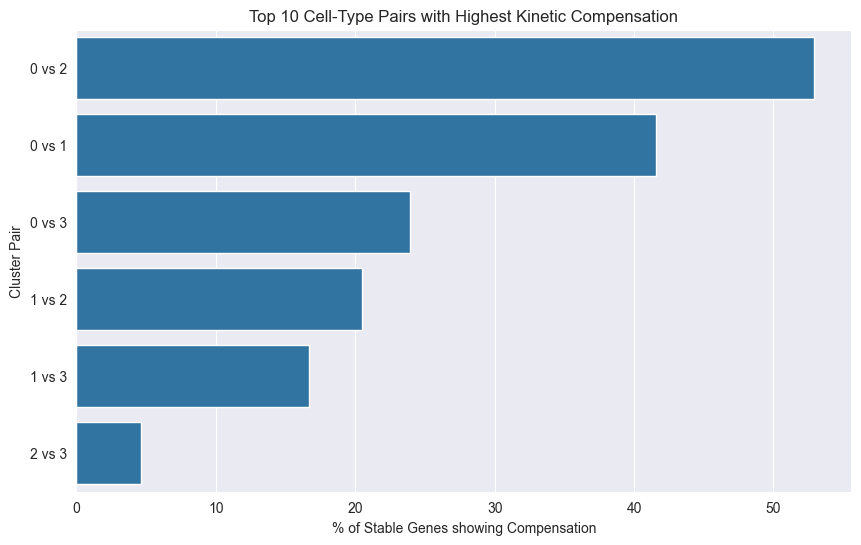


Interpretation: High percentages indicate cell-type pairs that look similar by mean expression but are mechanistically different.


In [25]:
# --- Plot a pairwise breakdown ---
df_res = pd.DataFrame(multi_pair_results).sort_values('pct_compensating', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(data=df_res.head(10), x='pct_compensating', y='pair')
plt.title("Top 10 Cell-Type Pairs with Highest Kinetic Compensation")
plt.xlabel("% of Stable Genes showing Compensation")
plt.ylabel("Cluster Pair")
plt.show()

print("\nInterpretation: High percentages indicate cell-type pairs that look similar by mean expression but are mechanistically different.")